In [1]:
# IMPORT VARIABLES, LIBRARIES AND FUNCTIONS
%matplotlib inline

from analysis_funk import * # Stored functions and variables to plot the map of Paris
from mvp_funk import * 
from clust_funk import *

print(data.shape, paris_attractions.shape)

(36858, 29) (449, 3)


In [2]:
mys = data.loc[:,['zipcode','latitude','longitude']].sample(frac=1)
mys.shape

(36858, 3)

---
# KNN attractions for every listing. 
#### Start with  k = 10

In [3]:
def get_distEuclid_from_attractions(x):
    d = np.sqrt((paris_attractions.longitude - x.longitude)**2 + (paris_attractions.latitude - x.latitude)**2)
    #return [d.sort_values()] # as a list of a serie
    return [d.values] # As a list of an array

***Takes 1 min***

In [4]:
# Get euclidean distance
mys['attraction'] = mys.apply(lambda x: get_distEuclid_from_attractions(x), axis=1)

In [7]:
# Transform list of distances into dataframe along with its listing id. 
all_dist = []
ndist = []
number_attr = paris_attractions.shape[0]

for idx, content in mys.iterrows():
    all_dist+=[list(np.repeat(idx,number_attr)),list(content.attraction[0][:number_attr])]

idx = []
for i in all_dist[0:-1:2]:
    idx+=i
for d in all_dist[1::2]:
    ndist+=d
    
nDist = pd.DataFrame({'listing' : idx, 'distance': ndist})

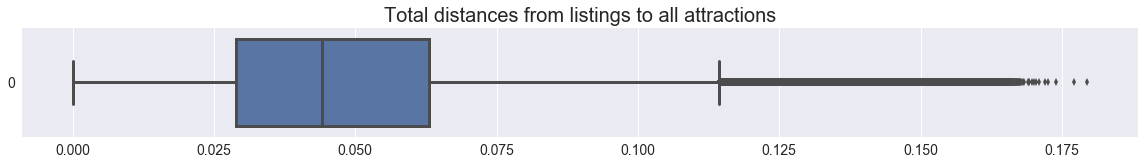

In [8]:
fig = plt.figure(figsize = (20,2))
sns.boxplot(data=nDist.distance, orient="h")
plt.title('Total distances from listings to all attractions')
plt.show()

---

***To grade the listings in terms of their proximity with the touristy places a listing having the longest distance to its closest attraction (top_dist) will have the minimum value. Then the value of a listing will increase as the number of attractions found within the radius set by top_dist. The listing having most of the attractions within that distance will therefore have the maximum score.*** 

In [9]:
print('Calculating location score ..')
# Get all listings' distance to their closest neighbor
closest_neighbor_distances = nDist.groupby('listing').min()
# Take the longest distance from that
top_dist = closest_neighbor_distances.loc[closest_neighbor_distances.idxmax().values[0]].distance
# Get all the listings with their distances below the top_dist
location_listings = nDist.loc[nDist.distance<=top_dist].groupby('listing').count().rename(columns={'distance':'num_of_attractions'}).sort_values('num_of_attractions', ascending=False)
# Grade the listings with a normalized metric reflecting the number of attractions. 
mys['location_score'] = location_listings.num_of_attractions.apply(lambda x: (x-min(location_listings.num_of_attractions))/(max(location_listings.num_of_attractions)-min(location_listings.num_of_attractions)))

print('Location score retrieved!')


Calculating location score ..
Location score retrieved!


In [232]:
mys.to_csv('../data/processed/mys.csv')

In [10]:
mys.sort_values('location_score', ascending=False).head()

zipcode  latitude  longitude  \
listing_id                                 
13430660      75005    48.851      2.346   
15612175      75005    48.851      2.346   
22298282      75005    48.851      2.346   
20245564      75005    48.851      2.346   
21809599      75005    48.851      2.346   

                                                   attraction  location_score  
listing_id                                                                     
13430660    [[0.00747669421365, 0.0118890595505, 0.0110580...           1.000  
15612175    [[0.00749218511113, 0.0118854231928, 0.0110408...           1.000  
22298282    [[0.00737390717875, 0.0117957534774, 0.0112372...           0.991  
20245564    [[0.00760161069353, 0.0116401009834, 0.0110370...           0.991  
21809599    [[0.00728742104168, 0.0119189908956, 0.0112781...           0.991

In [11]:
# Build dataframe with the number of listings having n number of attractions within the radius of top_dist
num_atrr_vs_num_list = location_listings.reset_index().groupby('num_of_attractions').count()      

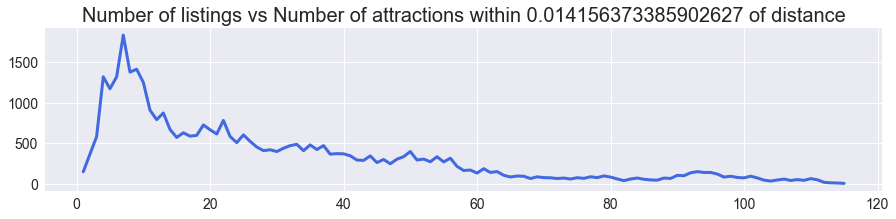

In [12]:
# Plot Number of listings vs Number of attractions
fig=plt.figure(figsize=(15,3))
plt.plot(num_atrr_vs_num_list.index, num_atrr_vs_num_list['listing'], marker='', color='royalblue', linewidth=3, alpha=1, label='Number of listings')
plt.title('Number of listings vs Number of attractions within {0} of distance'.format(top_dist))
plt.show()

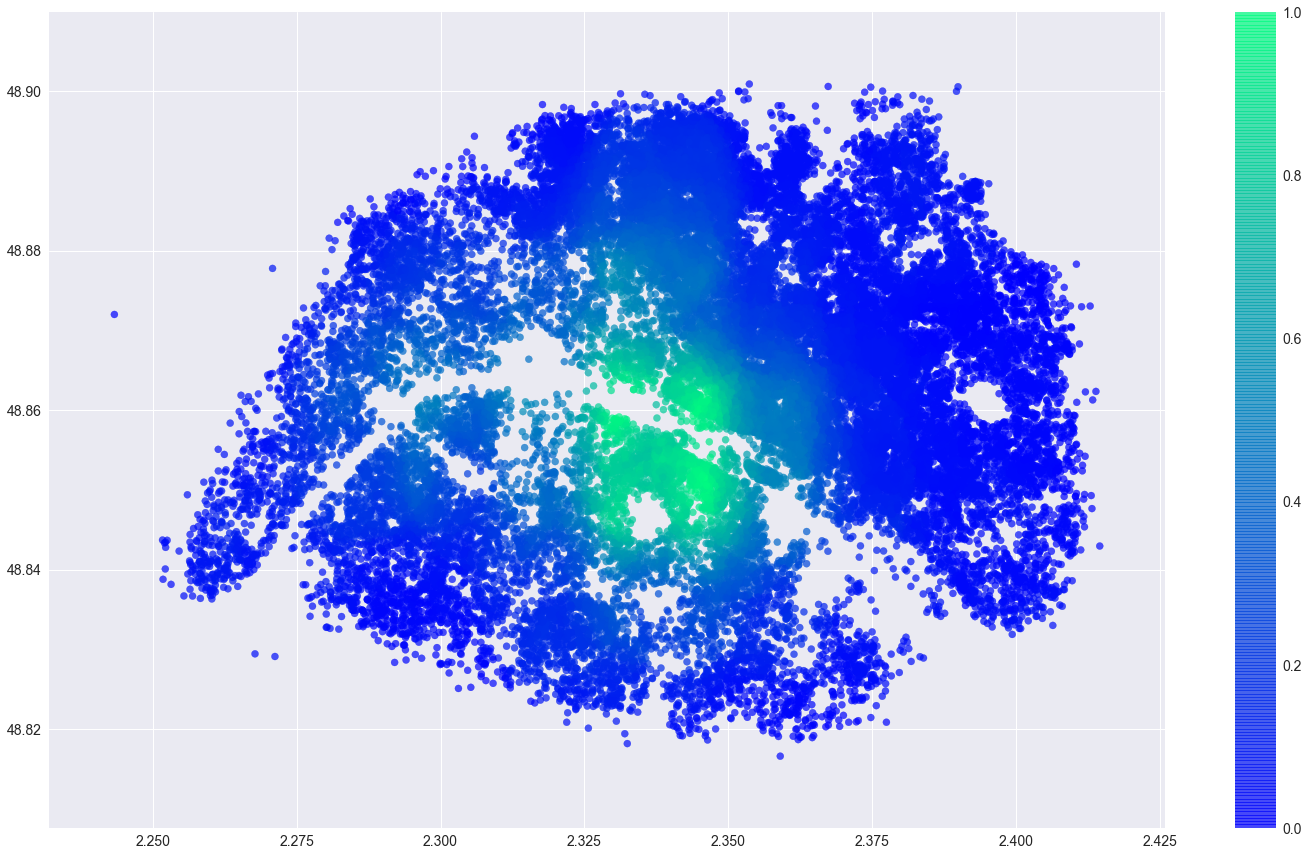

In [13]:
fig = plt.figure(figsize=(25,15))
plt.scatter(mys.longitude.values, mys.latitude.values, s=50, c=mys.location_score.values, cmap='winter' ,zorder=2, alpha=0.7)
plt.colorbar()
plt.show()

---

---
# LOCATION: 
- What is the proportion of listings per arrondissement? What is the reason? 


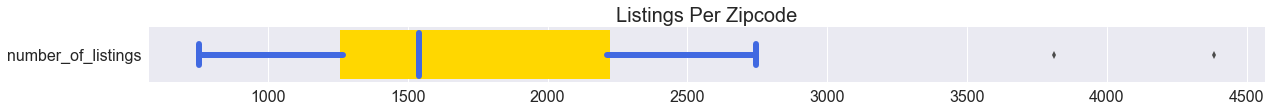

In [4]:
listings_per_zip = mys[['latitude','zipcode']].groupby('zipcode').count().rename(columns={'latitude':'number_of_listings'})
fig = plt.figure(figsize = (20,1))
sns.boxplot(data=listings_per_zip,
            orient="h", boxprops=dict(color='gold'), 
            capprops=dict(color='royalblue'), whiskerprops=dict(color='royalblue'),
            flierprops=dict(color='firebrick', markeredgecolor='firebrick'), 
            medianprops=dict(color='royalblue'))

plt.title('Listings Per Zipcode')
plt.show()

*We'll keep in mind that there are 2 districts that are overpopulated with listings: the 11th and 18th district. Whereas the 1st and the 8 have less than a thousand listings. This measure doesnt consider the density though, just the total number of listings.*

***Can I see the listings per zip in the map where every centroid of the district corresponds to a color in a scale? *** 

I think it will be usefull as it will tell me which how many listings are in the districts that are close to the attractions

- can we see which arrondissement is most expensive in function of the musings price? Which arrondissement has the most pricey listings? Does it correlate with the number of amenities? Or space? 

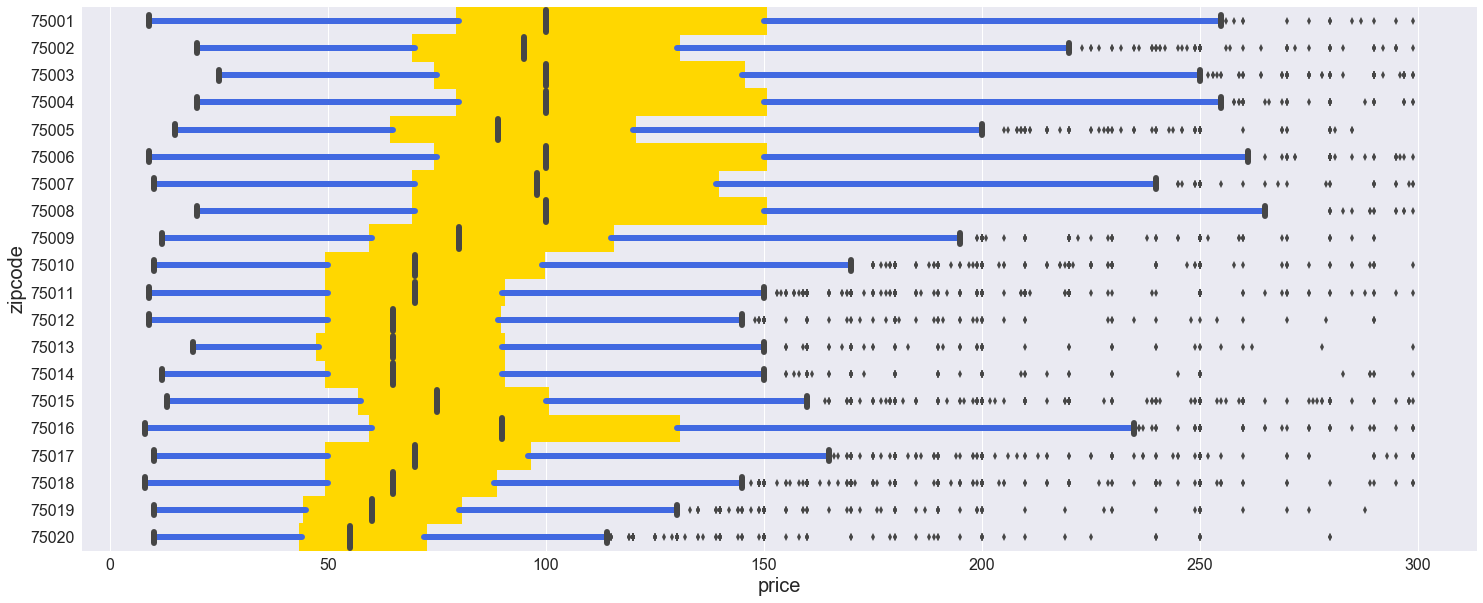

In [5]:
price_per_zip = data.loc[data.price<300, ['zipcode','price']]
fig = plt.figure(figsize = (25,10))
sns.boxplot(x='price',y='zipcode' ,data=price_per_zip, orient='h',
            boxprops=dict(color='gold'),
            whiskerprops=dict(color='royalblue'))
plt.show()

The median ranges from 50 to 100 dls and according to the plot above, the median is higher for districts closer to the center of the city (75001-75008) and slowly decreases for districts farther away from the center with the exception of the 16th district which is well-known to be one of the most expensive for . 


- should i include the feature of space? Yes if the variability of the price is pretty much the same in all zip codes 

___

# Clean listings coordinates

#### Get the outliers for every district and get the center of mass of every district with kmeans(1)

In [4]:
# From the listings coordinates, let's calculate the center of mass per zipcode and 
# through the LOF method get the wrong zipcodes. 
# Correct them by assigning the nearest zipcode center. 

centroids, outliers = get_centroids_and_outliers(data)

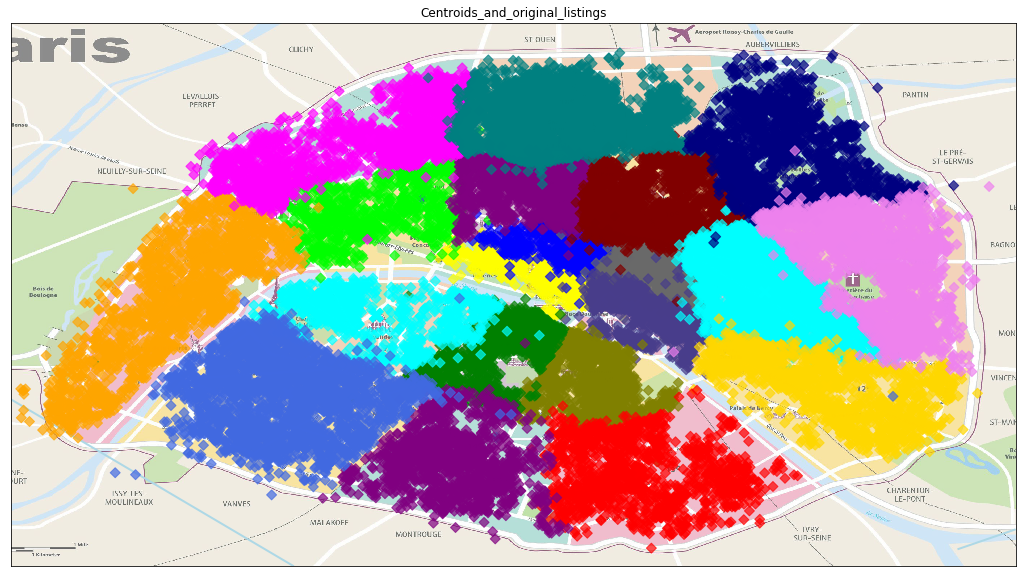

In [5]:
# Original data set with outliers: 
coord = data.loc[:,['latitude','longitude', 'zipcode']]#.sample(frac=0.1)
coord['color'] = coord.zipcode.apply(lambda x: cpzl[x])
print_paris(centroids, coord, 'c', 'Centroids_and_original_listings', False, 1, 0.6)

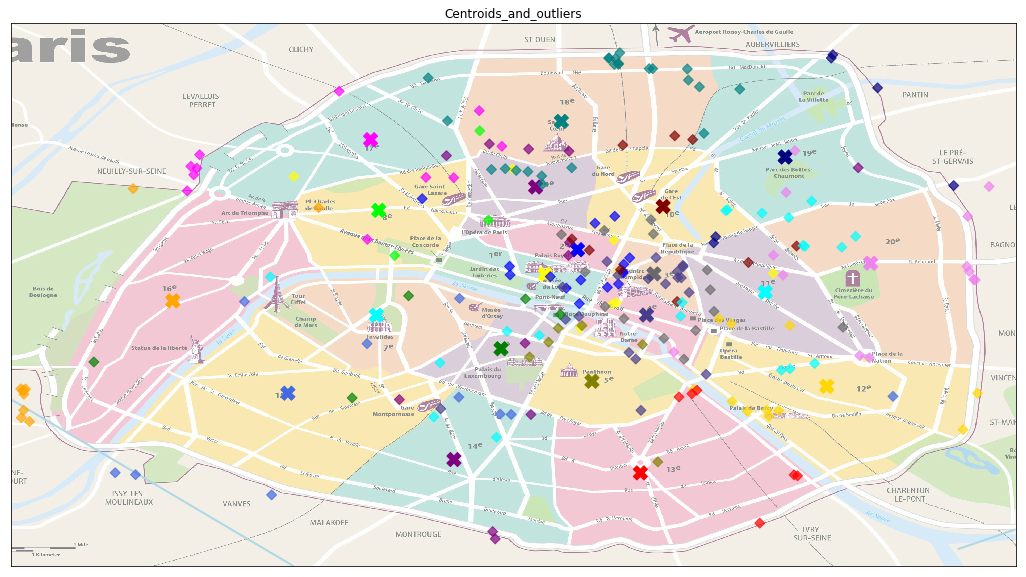

In [6]:
print_paris(centroids, outliers, 'c', 'Centroids_and_outliers', False, 1, 0.5)

In [17]:
# Function that returns the zipcode having the minimum euclidean
# distance with a particular listing x. Uses local variable centroids

def get_distEuclid_from_attractions(x):
    d = np.sqrt((centroids.longitude - x.longitude)**2 + (centroids.latitude - x.latitude)**2)
    return d.idxmin()

In [18]:
# For every outlier perform k nearest centroids (k=1). 
# In the centroids set, we compute the distance to every outlier listing and the 
# function get_distEuclid_centroids will return with the zipcode whose centroid is the nearest. 

outliers['zipcode'] = outliers.apply(lambda x: get_distEuclid_centroids(x), axis=1).astype(int)
# Update the color of the listing to its corresponding zipcode
outliers['color'] = outliers.zipcode.apply(lambda x: cpzl[x])


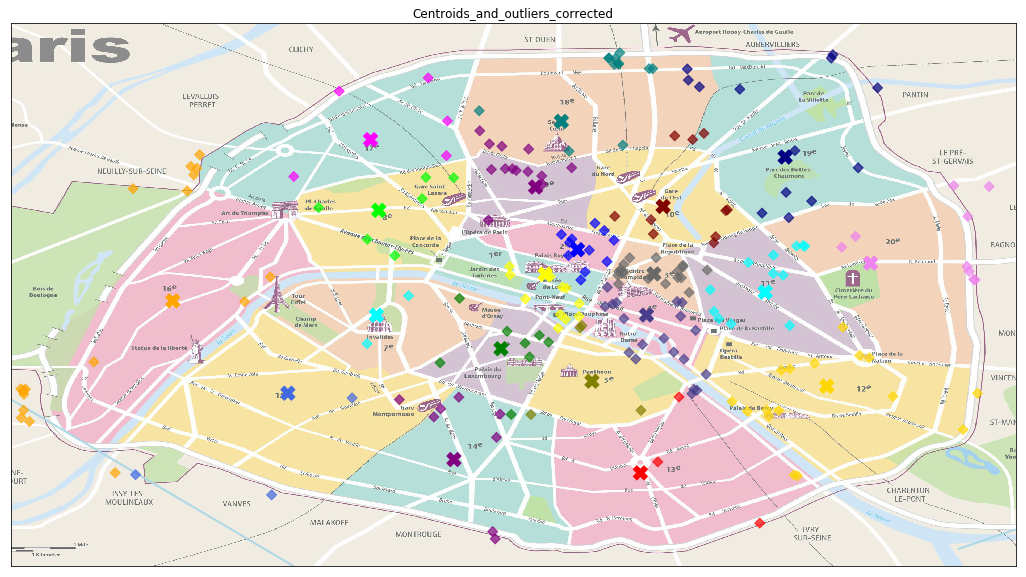

In [9]:
print_paris(centroids, outliers, 'c', 'Centroids_and_outliers_corrected', False, 1, 0.6)

In [10]:
# Add corrected outliers into database

data = pd.merge(data, outliers.loc[:,['zipcode']], right_index=True, left_index=True, how='outer')
# Get the index of those listings whose zipcode_y is not null. 
new_zip = data.loc[data.zipcode_y.notnull()].index.values
data.loc[new_zip,'zipcode_x'] = data.loc[new_zip,'zipcode_y']

data['zipcode'] = data.zipcode_x.astype(int)
data.drop(['zipcode_x','zipcode_y'], axis=1, inplace=True)

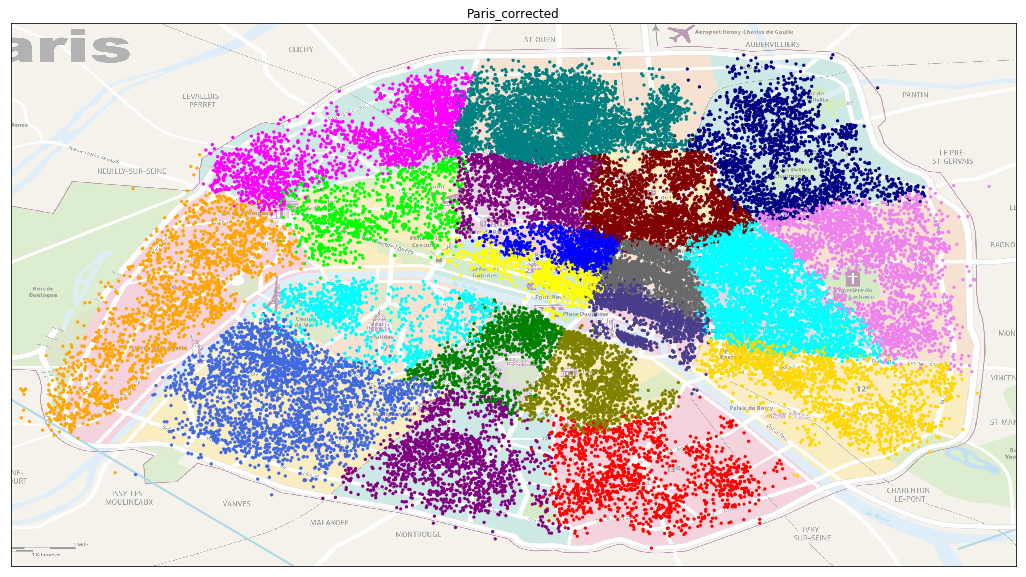

In [31]:
coord = data.loc[:,['latitude','longitude', 'zipcode']]#.sample(frac=0.1)
print_map(coord, res = 'c', arrn_lim = False, title_map='Paris_corrected', l_size=5, l_color = False, l_alf=1)


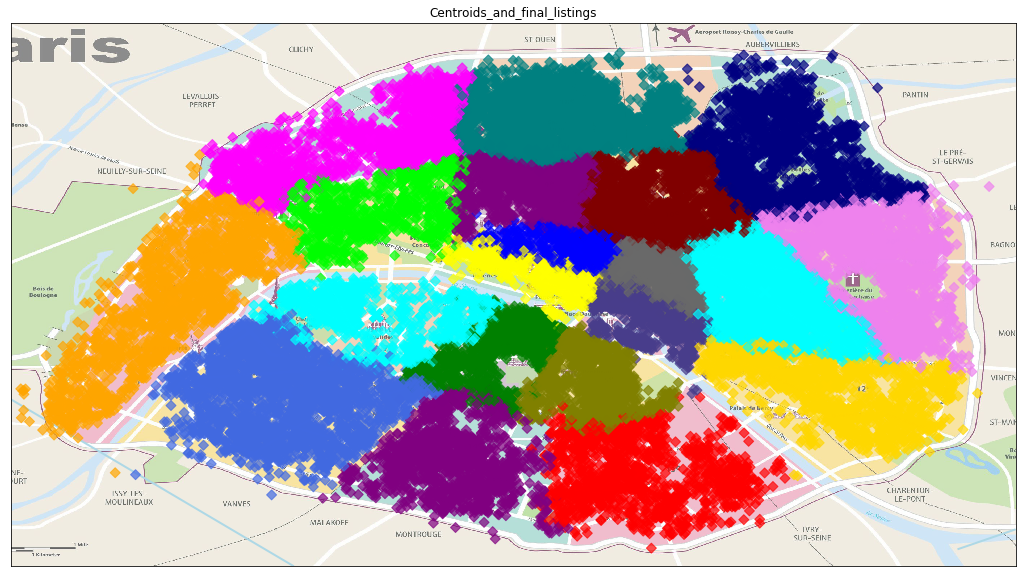

In [14]:
coord = data.loc[:,['latitude','longitude', 'zipcode']]#.sample(frac=0.1)
coord['color'] = coord.zipcode.apply(lambda x: cpzl[x])
print_paris(centroids, coord, 'c', 'Centroids_and_final_listings', False, 1, 0.6)

---

#### Other clustering methods

In [3]:
arrondissement = 75016
matXY = data.loc[data.zipcode==arrondissement,['longitude','latitude']].as_matrix()

In [4]:
# KMEANS
# Get the optimal k for every district
k = []
for arrondissement in data.zipcode.unique():

    kRange = range(1,10) # Range of k
    testKmeanXZ = test_kmeans(data.loc[data.zipcode.isin([arrondissement]),['longitude','latitude']].as_matrix(), kRange, display=False)
    k.append(get_optimal_k(testKmeanXZ))
print(k)
arrondissement = 75016

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


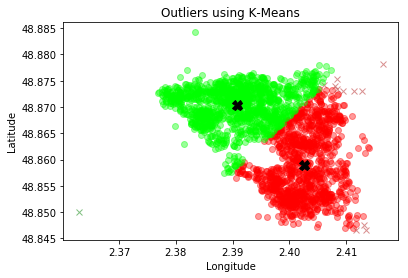

In [14]:
threshold = 7.4
X = data.loc[data.zipcode.isin([arrondissement]),['longitude','latitude']].values
centroids = get_kmeans(X, 2, threshold)

For the 16th district 2 centroids and a threshold of 7.4 will be enough to select the outliers that clearly stand out in plein sight. The nearest outlier (for class redd) is just a bit farther than the distance between the red centroid and its class neighbor. 

Every district's listing distribution is quite diferent from one another. 

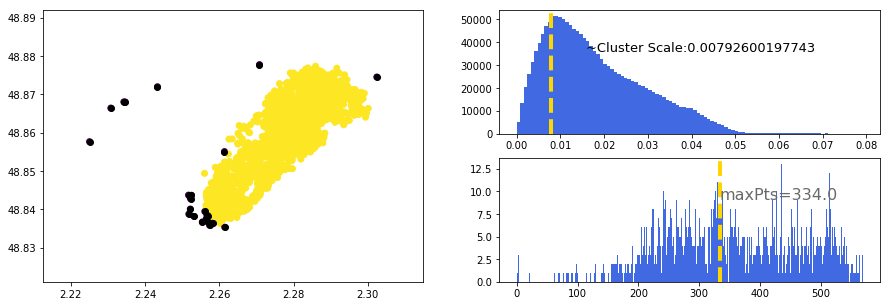

In [5]:
# DBSCAN
get_district_cluster(matXY, epsilon=False, max_pts=False)

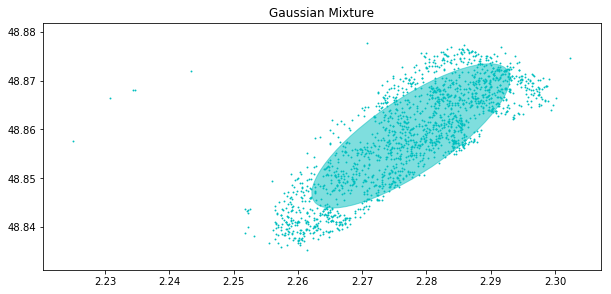

In [9]:
# GMM
X = data.loc[data.zipcode==arrondissement,['longitude','latitude']].values
get_gmm(X, n_components = 1)

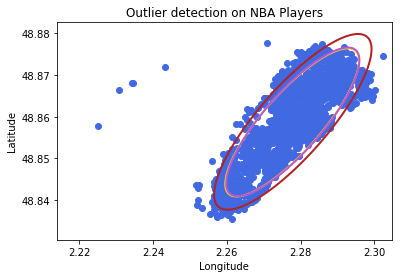

In [10]:
# Ellyptical Envelope - #### wouldnt work because all listings per zipcode are not normally distributed in terms of coordinates, unless... using PCA?? 
X1 = data.loc[(data.zipcode.isin([arrondissement])),['longitude','latitude']].values
get_elliptic_envelope(X1)

Solutions based on absolute density cannot detect local outliers. That's why we'll use LOF: 

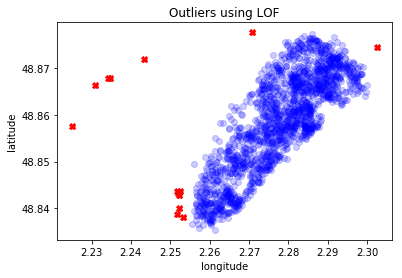

In [16]:
k = 25
df = data.loc[data.zipcode==arrondissement,['longitude','latitude']]

oust, inli = get_lof(df, k, True)

Looks like this method clears out the obvious outliers. 

---

---